<a id="Section_Title"></a>
# ** Data Analysis of the Boston Marathon Finishers by Gender**

The objective of this analysis is to develop a model to determine whether an athlete is Female or Male based on her or his split times during the race. 
The following is the roadmap of the study:
1. [Data Assessment](#section_DataAssesment)
2. [Data Exploration](#section_DataExploration)
3. [Predictive Models](#section_PredictiveModels)
> * [Random Forest](#section_RandomForest)
> * [Gradient Boost](#section_GradientBoost)
> * [XGBoost](#section_XGBoost)
4. [Results](#section_Results)
5. [Conclusion and Next Steps](#section_Conclusion)

<a id="section_DataAssesment"></a>
## **Data Assessment** 

In [1]:
# Importing relevant libraries 
import pandas as pd
import numpy as np
import scipy.stats
import pylab as plt
from matplotlib.colors import LogNorm

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc

import xgboost as xgb

In [2]:
# Loading 2017 data
data2017 = pd.read_csv('../input/marathon_results_2017.csv')
#np.unique(data2017['M/F'])

### Generalities of the data set

Data Dictionary
* Bib: Bib number - integer
* Name: Athlete's Name - string - format: Last,First
* Age: Athlete's Age - integer
* M/F: Athlete's Gender - string - format: {M/F}
* City: Athlete's City of Origin (US) - string
* State: Athlete's State of Origin (US) - string - format: XX
* Country: Athlete's Country of Origin - string - format: XXX
* Citizen: Athlete's Citizenship - string - format: XXX
* 5K: Time at 5K Mark - string - format: hh:mm:ss
* 10K: Time at 10K Mark - string - format: hh:mm:ss
* 15K: Time at 15K Mark - string - format: hh:mm:ss
* 20K: Time at 20K Mark - string - format: hh:mm:ss
* Half: Time at Half Marathon Mark - string - format: hh:mm:ss
* 25K: Time at 25K Mark - string - format: hh:mm:ss
* 30K: Time at 30K Mark - string - format: hh:mm:ss
* 35K: Time at 35K Mark - string - format: hh:mm:ss
* 40K: Time at 40K Mark - string - format: hh:mm:ss
* Pace: Athlete's Pace (average time per km) - string - format: hh:mm:ss
* Proj Time: Athete's Projected Time - string - format: hh:mm:ss
* Official Time: Athete's Official Time - string - format: hh:mm:ss
* Overall: Athlete's position overall - integer
* Gender: Athlete's position gender - integer
* Division: Athlete's position division - integer

In [3]:
# Number of athletes
NoA = len(data2017['Bib'])
NoFA = len(data2017[data2017['M/F']=='F']['Bib'])
NoMA = len(data2017[data2017['M/F']=='M']['Bib'])
print('Number of Athletes',NoA)
print('Number of Female Athletes',NoFA,'%.3g' % float(1.*NoFA/NoA))
print('Number of Male Athletes',NoMA,'%.3g' % float(1.*NoMA/NoA))
print('Female to Male Ratio', '%.3g' % float(1.*NoFA/NoMA))

Number of Athletes 26410
Number of Female Athletes 11972 0.453
Number of Male Athletes 14438 0.547
Female to Male Ratio 0.829


### Utilities - Useful Funtions

In [4]:
# Converting Times String into minutes
def getTimeMinutes(time_str):
    if time_str != '-':
        data_time = [int(item) for item in time_str.split(':')]
        return data_time[0]*60 + data_time[1] + data_time[2]/60. 
    else:
        return np.NaN

In [5]:
# Converting Genders into binary 
def getGender(gender_str):
    if gender_str == 'M':
        return 1
    else:
        return 0

In [6]:
# Print Readable Confusion Matrix
def print_cm(confusion_matrix, labels):
    cw = max([len(x) for x in labels]+[5])
    print(cw)
    
    print('{0:10}  {1}'.format(labels[0], labels[1]))

### Cleaning the Data - Selecting useful Columns and transforming Time and Gender Columns

In [7]:
data2017_WB = data2017[['Bib','Age', 'M/F','5K', '10K', '15K', '20K','Half', '25K', '30K', '35K', '40K','Official Time']]
lGENDER = data2017_WB['M/F'].apply(getGender)
lTime5K = data2017_WB['5K'].apply(getTimeMinutes)
lTime10K = data2017_WB['10K'].apply(getTimeMinutes)
lTime15K = data2017_WB['15K'].apply(getTimeMinutes)
lTime20K = data2017_WB['20K'].apply(getTimeMinutes)
lTimeHalf = data2017_WB['Half'].apply(getTimeMinutes)
lTime25K = data2017_WB['25K'].apply(getTimeMinutes)
lTime30K = data2017_WB['30K'].apply(getTimeMinutes)
lTime35K = data2017_WB['35K'].apply(getTimeMinutes)
lTime40K = data2017_WB['40K'].apply(getTimeMinutes)
lTimeFull = data2017_WB['Official Time'].apply(getTimeMinutes)


data2017_CL = pd.DataFrame({'Bib':data2017_WB['Bib'],'Age':data2017_WB['Age']})
data2017_CL['GenderB'] = lGENDER
data2017_CL['Time5K'] = lTime5K
data2017_CL['Time10K'] = lTime10K
data2017_CL['Time15K'] = lTime15K
data2017_CL['Time20K'] = lTime20K
data2017_CL['TimeHalf'] = lTimeHalf
data2017_CL['Time25K'] = lTime25K
data2017_CL['Time30K'] = lTime30K
data2017_CL['Time35K'] = lTime35K
data2017_CL['Time40K'] = lTime40K
data2017_CL['TimeFull'] = lTimeFull

# Selecting Athletes with valid data (all fields)
print(data2017_CL.shape)
print(data2017_CL.dropna().shape)
data2017_CL = data2017_CL.dropna()

(26410, 13)
(26259, 13)


In [8]:
# Number of athletes - Clean data
NoA_CL = len(data2017_CL['Bib'])
NoFA_CL = len(data2017_CL[data2017_CL['GenderB']==0]['Bib'])
NoMA_CL = len(data2017_CL[data2017_CL['GenderB']==1]['Bib'])
print('Number of Athletes - Clean Data',NoA_CL)
print('Number of Female Athletes - Clean Data',NoFA_CL,'%.3g' % float(1.*NoFA_CL/NoA_CL))
print('Number of Male Athletes - Clean Data',NoMA_CL,'%.3g' % float(1.*NoMA_CL/NoA_CL))
print('Female to Male Ratio - Clean Data', '%.3g' % float(1.*NoFA_CL/NoMA_CL))

Number of Athletes - Clean Data 26259
Number of Female Athletes - Clean Data 11913 0.454
Number of Male Athletes - Clean Data 14346 0.546
Female to Male Ratio - Clean Data 0.83


### Computing Paces and Intervals

In [9]:
data2017_CL['Pace5K'] = data2017_CL['Time5K']/5
data2017_CL['Pace10K'] = (data2017_CL['Time10K'] - data2017_CL['Time5K'])/5
data2017_CL['Pace15K'] = (data2017_CL['Time15K'] - data2017_CL['Time10K'])/5
data2017_CL['Pace20K'] = (data2017_CL['Time20K'] - data2017_CL['Time15K'])/5
data2017_CL['PaceHalf'] = (data2017_CL['TimeHalf'] - data2017_CL['Time20K'])/(21.1-20)
data2017_CL['Pace25K'] = (data2017_CL['Time25K'] - data2017_CL['TimeHalf'])/(25 - 21.1)
data2017_CL['Pace30K'] = (data2017_CL['Time30K'] - data2017_CL['Time25K'])/5
data2017_CL['Pace35K'] = (data2017_CL['Time35K'] - data2017_CL['Time30K'])/5
data2017_CL['Pace40K'] = (data2017_CL['Time40K'] - data2017_CL['Time35K'])/5
data2017_CL['PaceFull'] = (data2017_CL['TimeFull'] - data2017_CL['Time40K'])/(42.2 - 40)

data2017_CL['PaceMean'] = data2017_CL[['Pace5K', 'Pace10K', 'Pace15K', 'Pace20K', 'PaceHalf', 'Pace25K',
       'Pace30K', 'Pace35K', 'Pace40K', 'PaceFull']].mean(axis=1)
data2017_CL['PaceStd'] = data2017_CL[['Pace5K', 'Pace10K', 'Pace15K', 'Pace20K', 'PaceHalf', 'Pace25K',
       'Pace30K', 'Pace35K', 'Pace40K', 'PaceFull']].std(axis=1)

In [10]:
data2017_CL.head()
data2017_CL.columns.values

array(['Age', 'Bib', 'GenderB', 'Time5K', 'Time10K', 'Time15K', 'Time20K',
       'TimeHalf', 'Time25K', 'Time30K', 'Time35K', 'Time40K', 'TimeFull',
       'Pace5K', 'Pace10K', 'Pace15K', 'Pace20K', 'PaceHalf', 'Pace25K',
       'Pace30K', 'Pace35K', 'Pace40K', 'PaceFull', 'PaceMean', 'PaceStd'], dtype=object)

[Top](#Section_Title)

<a id="section_DataExploration"></a>
## **Data Exploration**

### General Population

Now that we have some of the features needed for the analysis, let's start the exploration of the data. As expected the Total Time is shows a  bell-shaped distribution. It shows a slow-rising curve for low TimeFull values and a sharp drop above 360 min (6 hours). 

In [11]:
# Computing relevant centrality meausures
mode = scipy.stats.mode(data2017_CL['TimeFull'])[0][0]
median = np.median(data2017_CL['TimeFull'])
mean = np.mean(data2017_CL['TimeFull'])

print('Mode of Distribution',mode)
print('Median of Distribution',median)
print('Mean of Distribution',mean)

Mode of Distribution 224.416666667
Median of Distribution 231.616666667
Mean of Distribution 238.00845868717954


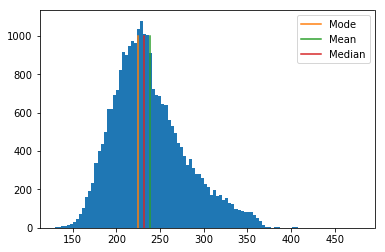

In [12]:
plt.hist(data2017_CL['TimeFull'],bins=100)
                   
plt.plot([mode,mode],[0,1000],label='Mode')
plt.plot([mean,mean],[0,1000],label='Mean')
plt.plot([median,median],[0,1000],label='Median')

plt.legend()
plt.show()

In [13]:
# Computing relevant dispersion meausures
std = np.std(data2017_CL['TimeFull'])
q25 = data2017_CL['TimeFull'].quantile(.25)
q75 = data2017_CL['TimeFull'].quantile(.75)

print('Standard Deviation of Distribution',std)
print('Quantile 25 of Distribution',q25)
print('Quantile 75 of Distribution',q75)

Standard Deviation of Distribution 42.12623342481214
Quantile 25 of Distribution 208.3
Quantile 75 of Distribution 261.76666666666665


### Full Time Distribution By Gender

The Two distributions (Female and Male) overlap towards the upper half of the distribution. 

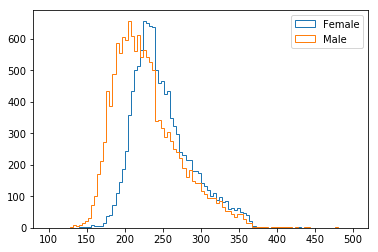

In [14]:
countsF, binsF, barsF = plt.hist(data2017_CL[data2017_CL['GenderB']==0]['TimeFull'],label='Female',histtype='step',bins=100,range=(100,500))
countsM, binsM, barsM = plt.hist(data2017_CL[data2017_CL['GenderB']==1]['TimeFull'],label='Male',histtype='step',bins=100,range=(100,500))
plt.legend()
plt.show()

The normalized histogram provides information about the likelihood that an athlete finished at a given. We can see how for low finishing times the probability of finishing is higher for male than for women.  

Threshold Time 216.0


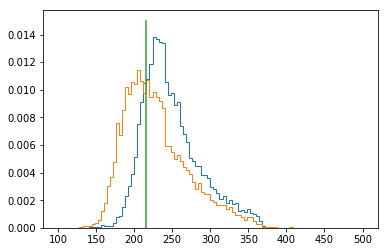

In [15]:
n_countsF, n_binsF, n_barsF = plt.hist(data2017_CL[data2017_CL['GenderB']==0]['TimeFull'],label='Female',histtype='step',bins=100,range=(100,500),normed=True)
n_countsM, n_binsM, n_barsM = plt.hist(data2017_CL[data2017_CL['GenderB']==1]['TimeFull'],label='Male',histtype='step',bins=100,range=(100,500),normed=True)
min_distribution_distance = ((n_countsF-n_countsM)**2)[np.all([150<n_binsF,n_binsF<250],axis=0)[:len(n_countsF)]].min()
time_threshold = n_binsF[np.argmin(((n_countsF-n_countsM)**2-min_distribution_distance)**2)]
plt.plot([time_threshold,time_threshold],[0,0.015])
print('Threshold Time', time_threshold)
plt.show()

### Pace Exploration

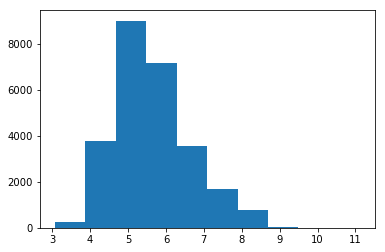

In [16]:
plt.hist(data2017_CL['PaceMean'])
plt.show()

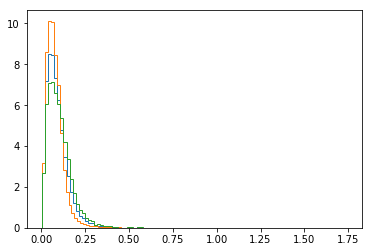

In [17]:
plt.hist(data2017_CL['PaceStd']/data2017_CL['PaceMean'],bins=100,histtype='step',normed='True')
plt.hist(data2017_CL[data2017_CL['GenderB']==0]['PaceStd']/data2017_CL[data2017_CL['GenderB']==0]['PaceMean'],bins=100,histtype='step',normed='True')
plt.hist(data2017_CL[data2017_CL['GenderB']==1]['PaceStd']/data2017_CL[data2017_CL['GenderB']==1]['PaceMean'],bins=100,histtype='step',normed='True')

plt.show()

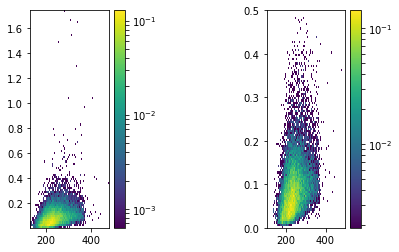

In [18]:
plt.subplot(1, 3, 1)
plt.hist2d(data2017_CL['TimeFull'],data2017_CL['PaceStd']/data2017_CL['PaceMean'],bins=(100,100),normed=True,norm=LogNorm())
plt.colorbar()
plt.subplot(1, 3, 3)
plt.hist2d(data2017_CL['TimeFull'],data2017_CL['PaceStd']/data2017_CL['PaceMean'],bins=(100,100),range=((100,500),(0,0.5)),normed=True,norm=LogNorm())
plt.colorbar()
plt.show()

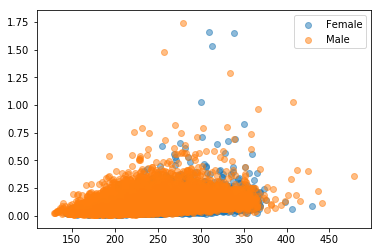

In [19]:
plt.scatter(data2017_CL[data2017_CL['GenderB']==0]['TimeFull'],data2017_CL[data2017_CL['GenderB']==0]['PaceStd']/data2017_CL[data2017_CL['GenderB']==0]['PaceMean'],alpha=0.5,label='Female')
plt.scatter(data2017_CL[data2017_CL['GenderB']==1]['TimeFull'],data2017_CL[data2017_CL['GenderB']==1]['PaceStd']/data2017_CL[data2017_CL['GenderB']==1]['PaceMean'],alpha=0.5,label='Male')
plt.legend()
plt.show()

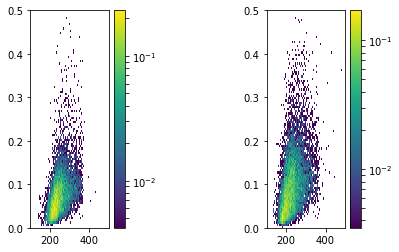

In [20]:
plt.subplot(1, 3, 1)
plt.hist2d(data2017_CL[data2017_CL['GenderB']==0]['TimeFull'],data2017_CL[data2017_CL['GenderB']==0]['PaceStd']/data2017_CL[data2017_CL['GenderB']==0]['PaceMean'],bins=(100,100),range=((100,500),(0,0.5)),normed=True,norm=LogNorm())
plt.colorbar()
plt.subplot(1, 3, 3)
plt.hist2d(data2017_CL[data2017_CL['GenderB']==1]['TimeFull'],data2017_CL[data2017_CL['GenderB']==1]['PaceStd']/data2017_CL[data2017_CL['GenderB']==1]['PaceMean'],bins=(100,100),range=((100,500),(0,0.5)),normed=True,norm=LogNorm())
plt.colorbar()
plt.show()

[Top](#Section_Title)

<a id="section_PredictiveModels"></a>
## **Predictive Models**

In [21]:
X = data2017_CL[['Age', 'Pace5K', 'Pace10K', 'Pace15K', 'Pace20K', 'PaceHalf', 'Pace25K','Pace30K', 'Pace35K', 'Pace40K', 'PaceFull']]
y = data2017_CL['GenderB']

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

<a id="section_RandomForest"></a>
### Random Forest

In [23]:
rfc = RandomForestClassifier(n_estimators=1000)
rfc.fit(X_train,y_train)
y_pred_rf = rfc.predict(X_test)
y_score_rf = rfc.predict_proba(X_test)[:, 1]
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_score_rf)
print('Random Forest ROC AUC', auc(fpr_rf, tpr_rf))
print(classification_report(y_test, y_pred_rf, target_names=['Female','Male']))

Random Forest ROC AUC 0.900211524615
             precision    recall  f1-score   support

     Female       0.80      0.81      0.81      3893
       Male       0.85      0.83      0.84      4773

avg / total       0.82      0.82      0.82      8666



<a id="section_GradientBoosting"></a>
### Gradient Boosting

In [24]:
gbc = GradientBoostingClassifier(n_estimators=1000)
gbc.fit(X_train,y_train)
y_pred_gb = gbc.predict(X_test)
y_score_gb = gbc.predict_proba(X_test)[:,1]
fpr_gb, tpr_gb, _ = roc_curve(y_test, y_score_gb)
print('Gradient Boosting ROC AUC', auc(fpr_gb, tpr_gb))
print(classification_report(y_test, y_pred_gb, target_names=['Female','Male']))

Gradient Boosting ROC AUC 0.899195448712
             precision    recall  f1-score   support

     Female       0.79      0.81      0.80      3893
       Male       0.84      0.83      0.84      4773

avg / total       0.82      0.82      0.82      8666



<a id="section_XGBoost"></a>
### XGBoost

In [25]:
xgbc = xgb.XGBClassifier()
xgbc.fit(X_train, y_train)
y_pred_xgb = xgbc.predict(X_test)
y_score_xgb = xgbc.predict_proba(X_test)[:,1]
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_score_xgb)
print('XGBoost ROC AUC', auc(fpr_xgb, tpr_xgb))
print(classification_report(y_test, y_pred_xgb, target_names=['Female','Male']))

XGBoost ROC AUC 0.892001491393
             precision    recall  f1-score   support

     Female       0.77      0.83      0.80      3893
       Male       0.85      0.80      0.82      4773

avg / total       0.81      0.81      0.81      8666



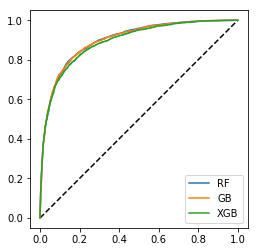

In [26]:
fig, ax = plt.subplots()
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.plot(fpr_gb, tpr_gb, label='GB')
plt.plot(fpr_xgb, tpr_xgb, label='XGB')
ax.set_aspect('equal')
plt.legend()
plt.show()

[Top](#Section_Title)

<a id="section_Results"></a>
## **Results**
The three predictive methods explored showed very similar performances. Given the complexity of the problem and the relatively small number of feauters in the data, specially demographic data, the results are very accurate. [Top](#Section_Title)

<a id="section_Conclusion"></a>
## **Conclusion and Next Steps**
The analysis of the performance of the athletes relative to gender was presented. Gender is a factor that influences the final time of the race as shown in the distribution of full times per gender. 

The three machine learning explored produced good results given the lack of features in the data. 
[Top](#Section_Title)